In [1]:
import gzip
import json
import pickle
import scipy.sparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from scipy import spatial
from tqdm.auto import tqdm
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-lcwvj1j5 because the default path (/home/i313924/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:
THREADS = 8

In [3]:
model = pd.read_pickle('/pio/scratch/1/i313924/lightfm_data/warp_model_100_epochs.pkl')

## Precision

In [5]:
interactions = scipy.sparse.load_npz('/pio/scratch/1/i313924/lightfm_data/interactions.npz')

In [5]:
# wziac popularnych uzytkownikow i produkty
interactions_sample = scipy.sparse.load_npz('/pio/scratch/1/i313924/lightfm_data/interactions_sample.npz')

In [ ]:
# Super time-consuming: https://github.com/lyst/lightfm/issues/510
precision_at_k(model, interactions_sample, k=5, num_threads=THREADS)

## ABX

In [4]:
dataset = pd.read_pickle('/pio/scratch/1/i313924/lightfm_data/dataset.pkl')
abx_tests = pd.read_json('/pio/scratch/1/i313924/test_data/test_ABX_weighted.json', lines=True)

In [5]:
abx_tests

,A,B,X,category_AX,category_B
0,B00Z730M1M,B00HZOJFWI,B00BXA6ZJQ,Women,Novelty & More
1,B00E3V35YK,B004LOFDB2,B00GXKDM1A,Women,Novelty & More
2,B01E5A13LA,B003XDTBS8,B01ERHV7R6,Women,Men
3,B004VQ19AY,B00JFAMADQ,B01D9O8Z3M,Women,Luggage & Travel Gear
4,B016Y82UPO,B005GTQQCQ,B016S2Z5HG,Men,Women
...,...,...,...,...,...
9995,B016ZNTZDS,B00AYCKUMW,B001KYU04G,Luggage & Travel Gear,Women
9996,B01CRKBVA8,B008FXIP8S,B00D8BR36M,Women,Men
9997,B014ERCUSE,B0016HSH6K,B0060QUJPY,Girls,Men
9998,B001T6IK42,B006NLKZD2,B007I7KE9A,Men,Novelty & More


In [6]:
def get_item_embedding(model, dataset, asin):
    item_id = dataset.mapping()[2][asin]
    return model.item_embeddings[item_id]

In [7]:
A = np.zeros((10000, 100))
B = np.zeros((10000, 100))
X = np.zeros((10000, 100))

In [8]:
for i, test in tqdm(abx_tests.iterrows()):
    A[i, :] = get_item_embedding(model, dataset, test["A"])
    B[i, :] = get_item_embedding(model, dataset, test["B"])
    X[i, :] = get_item_embedding(model, dataset, test["X"])

0it [00:00, ?it/s]

In [11]:
dist_A = ((A - X)**2).sum(axis=1)
dist_B = ((B - X)**2).sum(axis=1)

In [12]:
(dist_A < dist_B).mean()

0.5006

In [15]:
cos_dist_A = np.zeros(10000)
cos_dist_B = np.zeros(10000)
for i in tqdm(range(10000)):
    cos_dist_A[i] = spatial.distance.cosine(A[i, :], X[i, :])
    cos_dist_B[i] = spatial.distance.cosine(B[i, :], X[i, :])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
(cos_dist_A < cos_dist_B).mean()

0.5068

## Embeddings PCA

In [52]:
item_embeddings = pd.DataFrame(model.item_embeddings)
user_embeddings = pd.DataFrame(model.user_embeddings)

In [53]:
embeddings = pd.concat([item_embeddings, user_embeddings], keys=['items', 'users'])

In [54]:
embeddings.loc["items"]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.981894,0.434367,0.420056,-0.226862,-0.750322,0.378214,0.506877,-0.601498,-0.535883,-0.254038,...,-0.329986,-0.333889,-0.399537,-0.374377,1.262382,0.030474,0.047009,-0.170542,0.628366,0.612875
1,0.529865,-1.080727,0.739544,-0.600656,0.693816,0.361116,-0.825291,-1.125980,-0.632978,-0.607634,...,-0.793568,0.024270,1.096035,0.166134,0.487026,0.667935,0.212860,-0.596799,0.116543,-0.201067
2,-0.609469,0.518289,1.204239,-0.596764,0.332670,0.533632,0.324126,-0.165139,-0.299763,-0.553552,...,0.126669,-0.640331,-0.564327,-0.594578,-0.107549,0.445987,-0.174541,0.466444,-0.246159,0.649079
3,0.158128,0.039692,-0.244782,-0.696302,0.280271,1.076409,0.642269,0.290384,0.274619,-0.373836,...,0.754887,0.145727,-0.042573,0.897813,-0.241560,0.914475,-0.157003,-0.144312,-0.508414,-0.002511
4,0.425374,-0.081619,-0.256991,-0.033206,-0.468003,0.278293,-0.290486,-0.213585,0.379180,-0.349266,...,1.033496,-0.253434,-0.241456,0.843738,0.554167,0.183356,-0.192341,-0.103129,0.312469,0.066201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681292,0.115926,0.147580,0.097273,0.202346,0.171578,0.138605,0.171846,-0.154047,0.183990,0.015295,...,0.245627,-0.024627,-0.320821,-0.253190,-0.215574,0.051912,0.325542,0.055411,-0.133557,0.059084
2681293,-0.073440,0.213912,-0.032359,-0.071696,-0.042588,0.099876,0.081464,0.116539,0.108131,-0.233433,...,0.239629,0.174053,-0.334984,0.050963,-0.274776,0.202762,0.192957,0.142006,-0.144990,0.161833
2681294,0.178422,-0.111816,-0.322972,-0.111542,-0.003615,0.126519,-0.091284,-0.245530,-0.067650,-0.064876,...,0.178974,0.326226,0.292456,-0.100803,0.153543,-0.136172,0.327198,0.099004,0.153792,0.217548
2681295,0.008559,-0.011901,0.020901,0.023213,-0.020219,0.122425,-0.000290,-0.018245,-0.038252,0.015265,...,-0.014082,-0.004425,0.066371,-0.000408,0.019962,-0.081608,-0.019569,0.042282,0.051428,-0.031367


In [55]:
pca = PCA(n_components=2)
pca.fit(embeddings)

PCA(n_components=2)

In [56]:
reduced_item_embeddings = pd.DataFrame(pca.transform(embeddings.loc["items"]))
reduced_user_embeddings = pd.DataFrame(pca.transform(embeddings.loc["users"]))

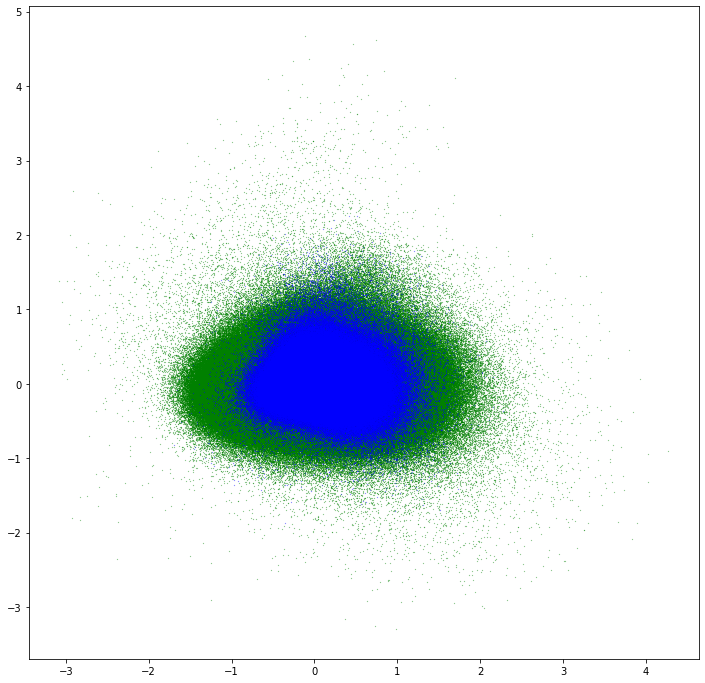

In [57]:
plt.figure(figsize=(12, 12))
plt.scatter(reduced_item_embeddings[0], reduced_item_embeddings[1], c='green', s=0.03)
plt.scatter(reduced_user_embeddings[0], reduced_user_embeddings[1], c='blue', s=0.03)

In [58]:
reduced_item_embeddings

,0,1
0,0.141930,-0.016142
1,-0.919365,-0.232407
2,-0.060087,-0.871400
3,0.591014,-0.038607
4,-0.063289,0.215876
...,...,...
2681292,0.139964,0.170451
2681293,-0.193253,0.225601
2681294,-1.132318,-0.498900
2681295,-0.145462,-0.085642


In [60]:
item_mapping = {v: k for k, v in dataset.mapping()[2].items()}
user_mapping = {v: k for k, v in dataset.mapping()[0].items()}

In [65]:
reduced_item_embeddings = reduced_item_embeddings.rename(index=item_mapping)

In [66]:
categories = pd.read_json('/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)

In [67]:
reduced_item_embeddings = reduced_item_embeddings.join(categories.set_index('asin'))

In [68]:
reduced_item_embeddings.columns = ['0', '1', 'category_1', 'category_2']

<AxesSubplot:xlabel='0', ylabel='1'>

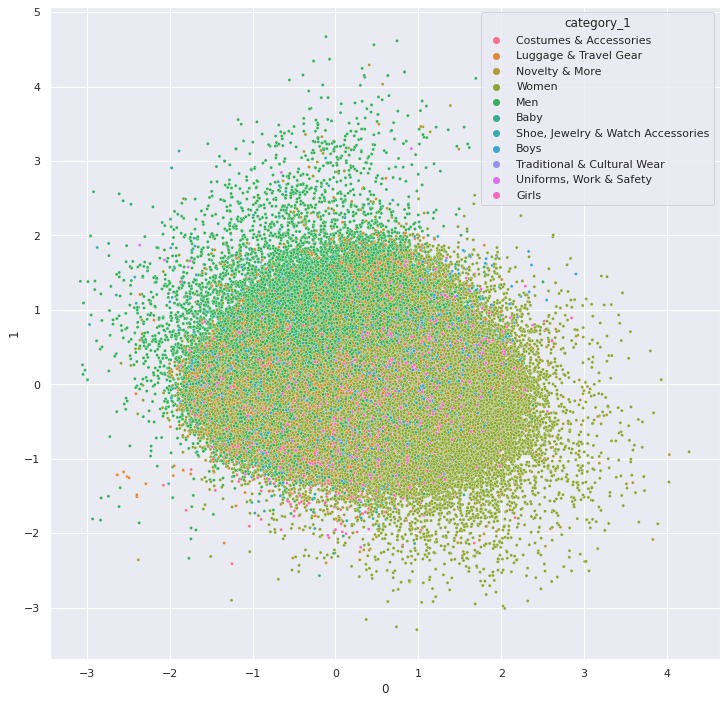

In [76]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings, hue='category_1', s=10)

<AxesSubplot:xlabel='0', ylabel='1'>

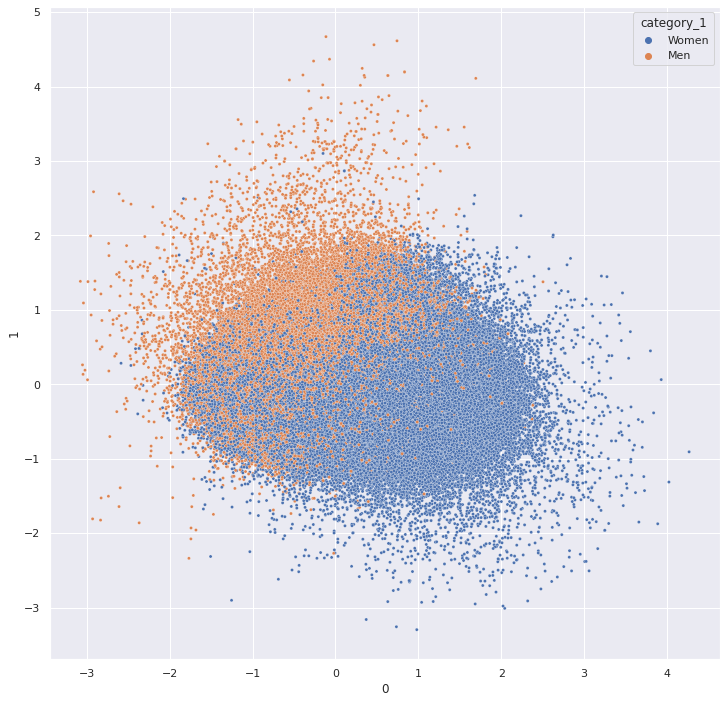

In [78]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Women', 'Men'])], hue='category_1', s=10)